In [1]:
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import plotnine as pn
from scipy.stats import ranksums
from datetime import datetime
import os

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.dpi'] = 150

In [3]:
pl.Config.set_fmt_str_lengths(100)

polars.config.Config

In [4]:
pn.theme_set(pn.theme_bw())
pn.theme_update(dpi=150)

In [5]:
os.chdir('/data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/plots')

In [6]:
# GTEx variants
variant_path = '/s/project/rep/processed/training_results_v16/gtex_v8_old_dna/private_variants.parquet/rare_variants.vcf.parquet/**/*.parquet'
# abexp benchmark dataset
gtex_benchmark_with_annotation_path = "/s/project/rep/processed/training_results_v16/gtex_benchmark_with_annotation.parquet/*.parquet"

In [7]:
variant_ldf = pl.scan_parquet(variant_path, hive_partitioning=True).select(['sampleId', 'chrom', 'start', 'end', 'ref', 'alt']).rename({'sampleId': 'individual',
                                                                                                                'start': 'variant_start',
                                                                                                                'end': 'variant_end'})

In [8]:
training_benchmark_ldf = (pl.scan_parquet(gtex_benchmark_with_annotation_path)
                          .select(['gene', 'individual', 'tissue', 'tissue_type', 'FDR', 
                                   'mu', 'zscore', 'l2fc'])
                          .unique()
                          .rename({'l2fc': 'l2fc_outrider'})
                          .with_columns((pl.when(pl.col('FDR') > 0.05)
                                         .then(pl.lit('normal'))
                                         .otherwise(
                                             pl.when(pl.col('zscore') > 0)
                                             .then(pl.lit('overexpressed'))
                                             .otherwise(
                                                 pl.when(pl.col('zscore') < 0)
                                                 .then(pl.lit('underexpressed'))
                                                 # this should never be the case
                                                 .otherwise(pl.lit('CHECK'))
                                             ))).cast(pl.Enum(['underexpressed', 'normal', 'overexpressed'])).alias('outlier_state')))

In [9]:
# OBVIOUS OUTLIERS
# (f.col("`vep@transcript_ablation.max`") == True)
  #               | (f.col("`vep@NMD_transcript_variant.max`") == True)
  #               | (f.col("`vep@LoF_HC.max`") == True)
  #               | (f.col("`vep@stop_gained.max`") == True)
  #               | (f.col("`vep@frameshift_variant.max`") == True)
  #               | (f.col("AbExp") <= f.lit(-1.3049192425217895))

In [10]:
variant_ldf.head().collect()

individual,chrom,variant_start,variant_end,ref,alt
str,str,i64,i64,str,str
"""GTEX-1117F""","""chr1""",133957,133960,"""CCT""","""C"""
"""GTEX-1117F""","""chr1""",234426,234434,"""GACACACC""","""G"""
"""GTEX-1117F""","""chr1""",234436,234437,"""A""","""ATG"""
"""GTEX-1117F""","""chr1""",532044,532045,"""C""","""A"""
"""GTEX-1117F""","""chr1""",819127,819128,"""G""","""A"""


IndentationError: unexpected indent (1299731563.py, line 2)

In [12]:
individuals = training_benchmark_ldf.select('individual').unique().collect().to_numpy().flatten()

### How many individuals

In [13]:
len(individuals)

633

In [14]:
# only keep the variants from the individuals in the benchmark
variant_ldf = variant_ldf.filter(pl.col('individual').is_in(individuals))

### How many tissues and tissue types?

In [15]:
tissues = training_benchmark_ldf.select('tissue').unique().collect().to_numpy().flatten()

In [16]:
tissue_types = training_benchmark_ldf.select('tissue_type').unique().collect().to_numpy().flatten()

In [17]:
len(tissues)

49

In [18]:
len(tissue_types)

27

### How many total samples? (individual, tissue)

In [13]:
samples = training_benchmark_ldf.select(['individual', 'tissue']).unique().collect().to_numpy().flatten()

In [30]:
samples

array(['GTEX-14ICL', 'Adipose - Subcutaneous', 'GTEX-16XZZ', ...,
       'Adrenal Gland', 'GTEX-PX3G', 'Spleen'], dtype=object)

In [18]:
training_benchmark_ldf.columns

/scratch/tmp/tsi/ipykernel_3479934/759182082.py:1: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.


['gene',
 'individual',
 'tissue',
 'tissue_type',
 'FDR',
 'mu',
 'zscore',
 'l2fc_outrider',
 'outlier_state']

In [25]:
pl.scan_parquet(gtex_benchmark_with_annotation_path).select('is_in_benchmark').unique().collect()

is_in_benchmark
bool
true


In [29]:
pl.scan_parquet(gtex_benchmark_with_annotation_path).select(['individual', 'tissue']).unique().collect()

individual,tissue
str,str
"""GTEX-ZG7Y""","""Esophagus - Muscularis"""
"""GTEX-1AX9J""","""Esophagus - Gastroesophageal Junction"""
"""GTEX-1GTWX""","""Adipose - Subcutaneous"""
"""GTEX-1B97I""","""Breast - Mammary Tissue"""
"""GTEX-11TTK""","""Brain - Cerebellum"""
…,…
"""GTEX-13QJ3""","""Testis"""
"""GTEX-111CU""","""Pancreas"""
"""GTEX-13NZB""","""Artery - Tibial"""


### How many rare variants per individual?

In [21]:
variant_ldf.select(pl.len()).collect()

len
u32
17529462


In [22]:
variant_ldf.group_by('individual').agg(pl.len()).select(pl.col('len').median()).collect()

len
f64
22280.0


In [23]:
variant_ldf.with_columns(indel=(pl.col('ref').str.len_chars() != pl.col('alt').str.len_chars()),
                         snp=((pl.col('ref').str.len_chars() == 1) & (pl.col('alt').str.len_chars() == 1))
                        ).select(indel_len=pl.col('indel').sum(), snp_len=pl.col('snp').sum(), total_len=pl.len()
                                ).with_columns(indel_snp_sum=pl.col('indel_len') + pl.col('snp_len')).collect()

indel_len,snp_len,total_len,indel_snp_sum
u32,u32,u32,u32
1324798,16204664,17529462,17529462


In [24]:
variant_ldf.with_columns(indel=(pl.col('ref').str.len_chars() != pl.col('alt').str.len_chars())
                        ).group_by('individual').agg(snp_len=(~pl.col('indel')).sum(), indel_len=pl.col('indel').sum()
                                                    ).select(pl.col('snp_len').median(), pl.col('indel_len').median()).collect()

snp_len,indel_len
f64,f64
20595.0,1677.0


### How many genes?

In [25]:
training_benchmark_ldf.select('gene').unique().select(pl.len()).collect()

len
u32
18171


### How many expression outliers?

In [25]:
training_benchmark_ldf.group_by('outlier_state').agg(pl.len()).collect()

outlier_state,len
enum,u32
"""underexpressed""",11200
"""normal""",99434253
"""overexpressed""",14464


In [26]:
training_benchmark_ldf.group_by(['outlier_state', 'individual']).agg(pl.len()).group_by('outlier_state').agg(pl.col('len').median()).collect()

outlier_state,len
enum,f64
"""underexpressed""",13.0
"""normal""",155334.0
"""overexpressed""",19.0


In [27]:
training_benchmark_ldf.group_by(['outlier_state', 'individual', 'tissue_type']).agg(pl.len()).group_by('outlier_state').agg(pl.col('len').median()).collect()

outlier_state,len
enum,f64
"""underexpressed""",2.0
"""normal""",9838.0
"""overexpressed""",2.0


In [28]:
training_benchmark_ldf.group_by(['outlier_state', 'individual', 'tissue_type']).agg(pl.len()).group_by('outlier_state').agg(pl.col('len').median()).collect()

outlier_state,len
enum,f64
"""underexpressed""",2.0
"""normal""",9838.0
"""overexpressed""",2.0


### Tissue counts

In [103]:
df = training_benchmark_ldf.select(['individual', 'tissue_type']).unique().group_by('tissue_type').agg(pl.len()).collect()

In [104]:
ordered_tissues = df.sort('len', descending=True)['tissue_type']

In [105]:
df = df.with_columns(pl.col('tissue_type').cast(pl.Enum(ordered_tissues)))

In [106]:
# Create the bar plot
p =(pn.ggplot(df, pn.aes(x='tissue_type', y='len')) +
        pn.geom_bar(stat='identity', fill='gray') + 
        pn.theme(
            figure_size=(6, 2.5),
            axis_text_x=pn.element_text(angle=90),
            dpi=150
        ) +
        pn.labs(y='Individual count', x='', title=''))

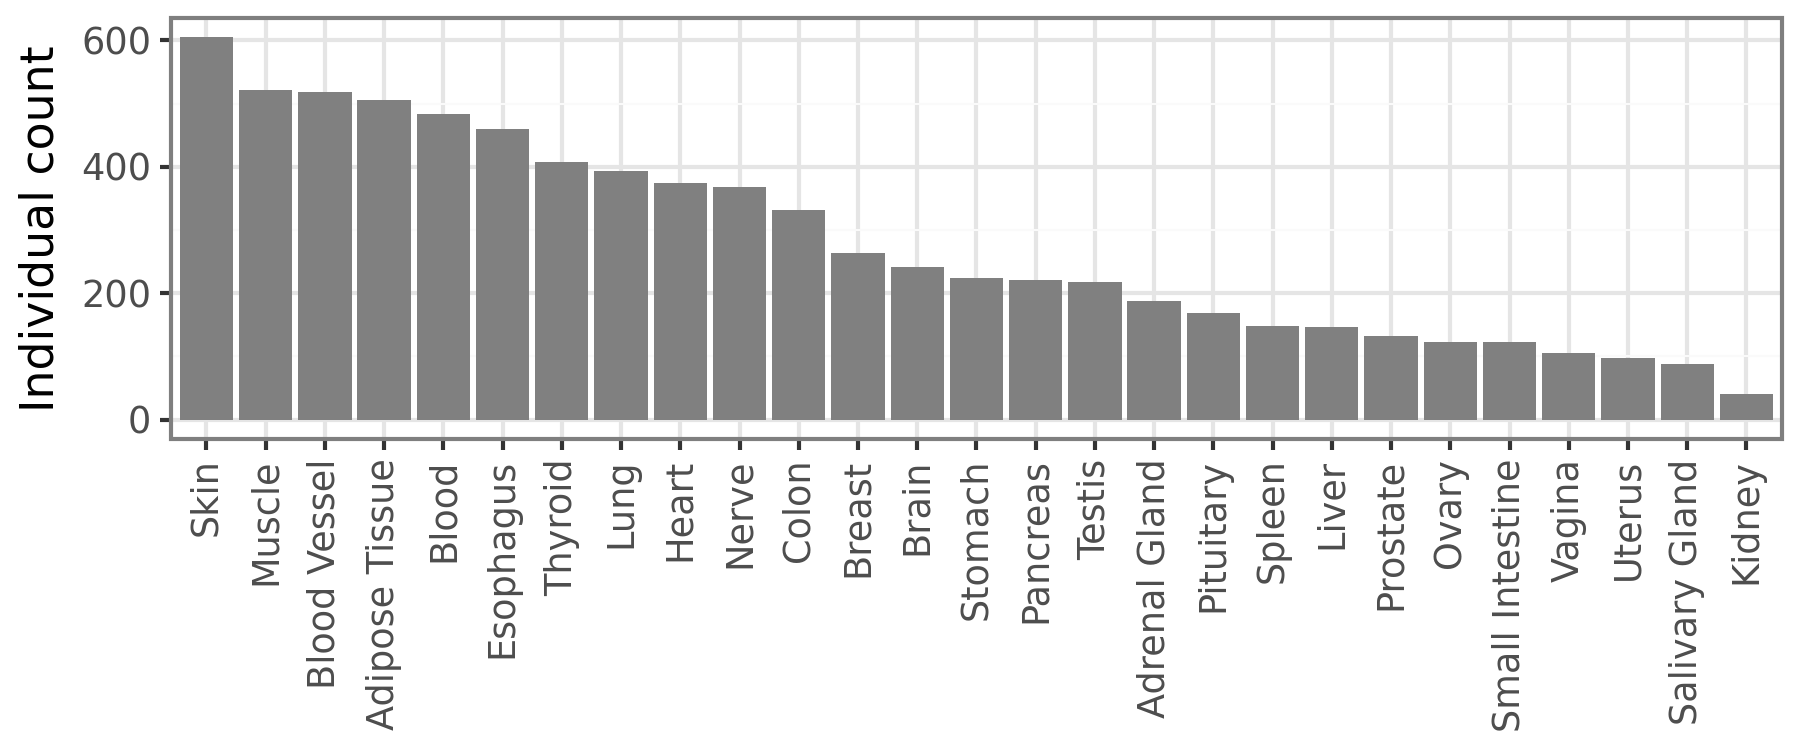

In [107]:
p

In [108]:
p.save("tissues.pdf", width=6, height=2.5, dpi=300)

/opt/modules/i12g/anaconda/envs/kipoi-veff-analysis/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 2.5 in image.
/opt/modules/i12g/anaconda/envs/kipoi-veff-analysis/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: tissues.pdf


### Outliers per tissue type

In [109]:
df = training_benchmark_ldf.group_by(['tissue_type', 'outlier_state']).agg(pl.len()).collect()

In [110]:
df = df.filter(pl.col('outlier_state') != 'normal')

In [111]:
df = df.with_columns(pl.col('outlier_state').cast(pl.Enum(['underexpressed', 'overexpressed'])))

In [112]:
ordered_tissues = df.group_by('tissue_type').agg(pl.col('len').sum()).sort('len', descending=True)['tissue_type']

In [113]:
df = df.with_columns(pl.col('tissue_type').cast(pl.Enum(ordered_tissues)))

In [114]:
# Create the bar plot
p = (pn.ggplot(df, pn.aes(x='tissue_type', y='len', fill='outlier_state')) +
        pn.geom_bar(stat='identity', position='dodge') +
        pn.scale_fill_manual(['#D3D3D3', '#A9A9A9']) +
        pn.theme(
            figure_size=(6, 2.5),
            axis_text_x=pn.element_text(angle=90),
            dpi=150,
            legend_position = (0.9, 0.8),
            legend_background=pn.element_rect(fill='white', color='black', size=0.3)
        ) +
        pn.labs(y='Outlier count', x='', title='', fill='Outlier state'))

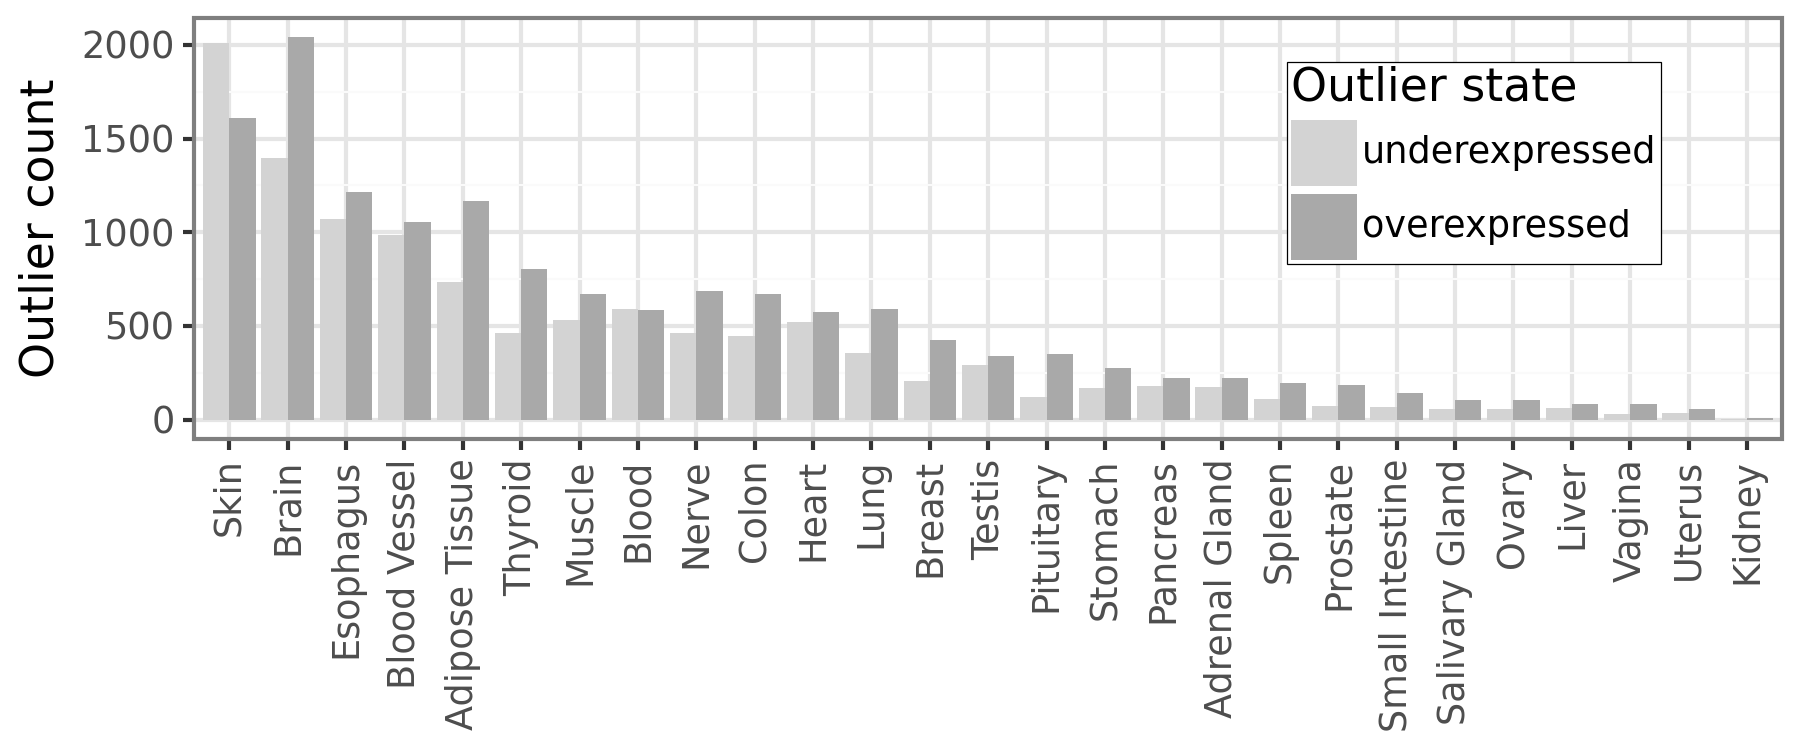

In [115]:
p

In [117]:
p.save("outlier_tissues.pdf", width=6, height=2.5, dpi=300)

/opt/modules/i12g/anaconda/envs/kipoi-veff-analysis/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 2.5 in image.
/opt/modules/i12g/anaconda/envs/kipoi-veff-analysis/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: outlier_tissues.pdf


### Outliers per tissue

In [118]:
df = training_benchmark_ldf.group_by(['individual', 'tissue_type', 'outlier_state']).agg(pl.len()).group_by(['tissue_type', 'outlier_state']).agg(pl.col('len').median()).collect()

In [119]:
df = df.filter(pl.col('outlier_state') != 'normal')

In [120]:
df = df.with_columns(pl.col('outlier_state').cast(pl.Enum(['underexpressed', 'overexpressed'])))

In [121]:
ordered_tissues = df.group_by('tissue_type').agg(pl.col('len').sum()).sort('len', descending=True)['tissue_type']

In [122]:
df = df.with_columns(pl.col('tissue_type').cast(pl.Enum(ordered_tissues)))

In [123]:
# Create the bar plot
p = (pn.ggplot(df, pn.aes(x='tissue_type', y='len', fill='outlier_state')) +
        pn.geom_bar(stat='identity', position='dodge') +
        pn.scale_fill_manual(['#D3D3D3', '#A9A9A9']) +
        pn.theme(
            figure_size=(6, 2.5),
            axis_text_x=pn.element_text(angle=90),
            dpi=150,
            legend_position = (0.9, 0.8),
            legend_background=pn.element_rect(fill='white', color='black', size=0.3)
        ) +
        pn.labs(y='Median outlier\ncount', x='', title='', fill='Outlier state'))

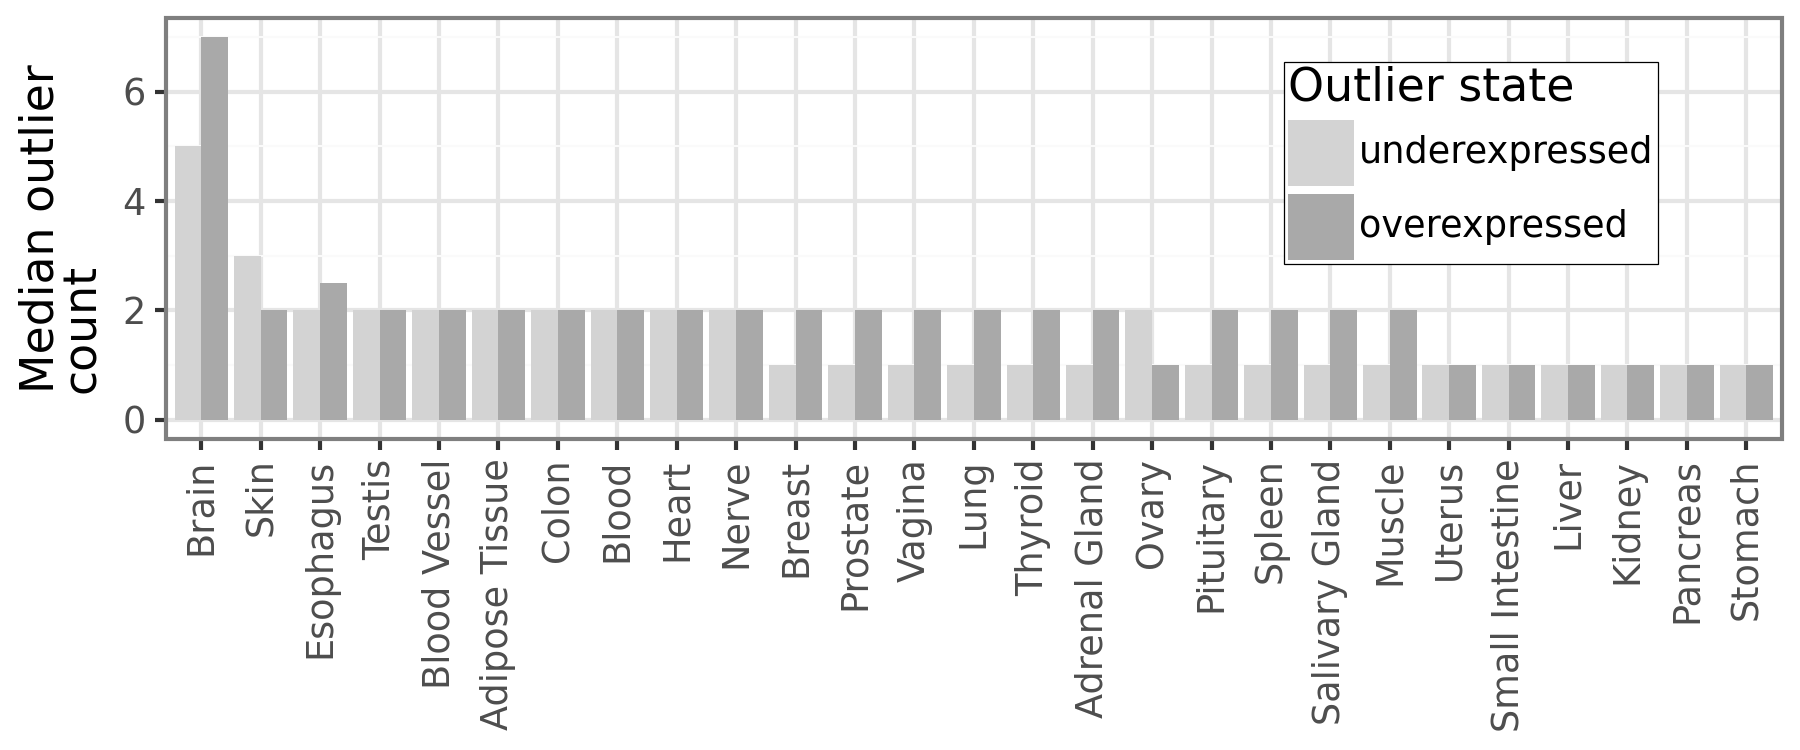

In [124]:
p

In [126]:
p.save("median_outlier_tissues.pdf", width=6, height=2.5, dpi=300)

/opt/modules/i12g/anaconda/envs/kipoi-veff-analysis/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 2.5 in image.
/opt/modules/i12g/anaconda/envs/kipoi-veff-analysis/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: median_outlier_tissues.pdf


In [43]:
df = training_benchmark_ldf.group_by('outlier_state').agg(pl.len()).collect()

In [44]:
df.with_columns(total=pl.col('len').sum()).with_columns(pl.col('len') / pl.col('total'))

outlier_state,len,total
enum,f64,u32
"""overexpressed""",0.000145,99459917
"""underexpressed""",0.000113,99459917
"""normal""",0.999742,99459917


### How many tissues per individual?

In [45]:
df1 = training_benchmark_ldf.select(['tissue', 'individual']).unique().group_by('individual').agg(pl.len()).collect()

In [46]:
df1.select(pl.col('len').median())

len
f64
17.0


In [47]:
df2 = training_benchmark_ldf.with_columns(total_samples=pl.len().over(['individual', 'gene'])).group_by('gene', 'individual', 'outlier_state', 'total_samples').agg(num_samples=pl.len(), ).collect()

In [48]:
df2 = df2.with_columns(proportion=pl.col('num_samples') / pl.col('total_samples'))

In [49]:
p = (pn.ggplot(df2.filter(pl.col('outlier_state') != 'normal'), pn.aes(y='proportion', x='outlier_state')) + pn.geom_boxplot() + 
    pn.theme(
            figure_size=(4, 4),
            dpi=150,
        ) +
        pn.labs(y='Sample proportion', x='', title='Samples per outlier'))

In [50]:
p.save("sample_proportion_outlier.pdf", width=4, height=4, dpi=300)

/opt/modules/i12g/anaconda/envs/kipoi-veff-analysis/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4 x 4 in image.
/opt/modules/i12g/anaconda/envs/kipoi-veff-analysis/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: sample_proportion_outlier.pdf


### Outliers per gene

In [51]:
df = training_benchmark_ldf.select(['individual', 'gene', 'outlier_state']).group_by(['gene', 'outlier_state']).agg(pl.len()).collect()

In [52]:
df = df.filter(pl.col('outlier_state') != 'normal')

In [53]:
df = df.with_columns(pl.col('outlier_state').cast(pl.Enum(['underexpressed', 'overexpressed'])))

In [54]:
under_df = df.filter(pl.col('outlier_state') == 'underexpressed')
over_df = df.filter(pl.col('outlier_state') == 'overexpressed')

In [55]:
under_df

gene,outlier_state,len
str,enum,u32
"""ENSG00000109917""","""underexpressed""",1
"""ENSG00000115902""","""underexpressed""",2
"""ENSG00000088808""","""underexpressed""",1
"""ENSG00000197565""","""underexpressed""",1
"""ENSG00000140365""","""underexpressed""",1
…,…,…
"""ENSG00000133138""","""underexpressed""",7
"""ENSG00000140391""","""underexpressed""",1
"""ENSG00000177946""","""underexpressed""",3


In [56]:
over_df

gene,outlier_state,len
str,enum,u32
"""ENSG00000165731""","""overexpressed""",2
"""ENSG00000145911""","""overexpressed""",1
"""ENSG00000165795""","""overexpressed""",1
"""ENSG00000198961""","""overexpressed""",1
"""ENSG00000155849""","""overexpressed""",1
…,…,…
"""ENSG00000111912""","""overexpressed""",2
"""ENSG00000092330""","""overexpressed""",3
"""ENSG00000130234""","""overexpressed""",1


In [57]:
over_df = over_df.sort('len', descending=True)[:10]
under_df = under_df.sort('len', descending=True)[:10]

In [58]:
import mygene
mg = mygene.MyGeneInfo()

over_gene_info = mg.querymany(over_df['gene'].to_list(), scopes='ensembl.gene', fields='symbol', species='human')
under_gene_info = mg.querymany(under_df['gene'].to_list(), scopes='ensembl.gene', fields='symbol', species='human')

querying 1-10...done.
Finished.
querying 1-10...done.
Finished.


In [59]:
ugs = [g['symbol'] for g in under_gene_info]
ogs = [g['symbol'] for g in over_gene_info]

over_df = over_df.with_columns(symbol=pl.Series(ogs).cast(pl.Enum(ogs)))
under_df = under_df.with_columns(symbol=pl.Series(ugs).cast(pl.Enum(ugs)))

In [60]:
over_df

gene,outlier_state,len,symbol
str,enum,u32,enum
"""ENSG00000213780""","""overexpressed""",52,"""GTF2H4"""
"""ENSG00000177646""","""overexpressed""",48,"""ACAD9"""
"""ENSG00000066827""","""overexpressed""",41,"""ZFAT"""
"""ENSG00000169682""","""overexpressed""",40,"""SPNS1"""
"""ENSG00000184277""","""overexpressed""",39,"""TM2D3"""
"""ENSG00000126457""","""overexpressed""",37,"""PRMT1"""
"""ENSG00000101882""","""overexpressed""",37,"""NKAP"""
"""ENSG00000132300""","""overexpressed""",34,"""PTCD3"""
"""ENSG00000133316""","""overexpressed""",33,"""WDR74"""


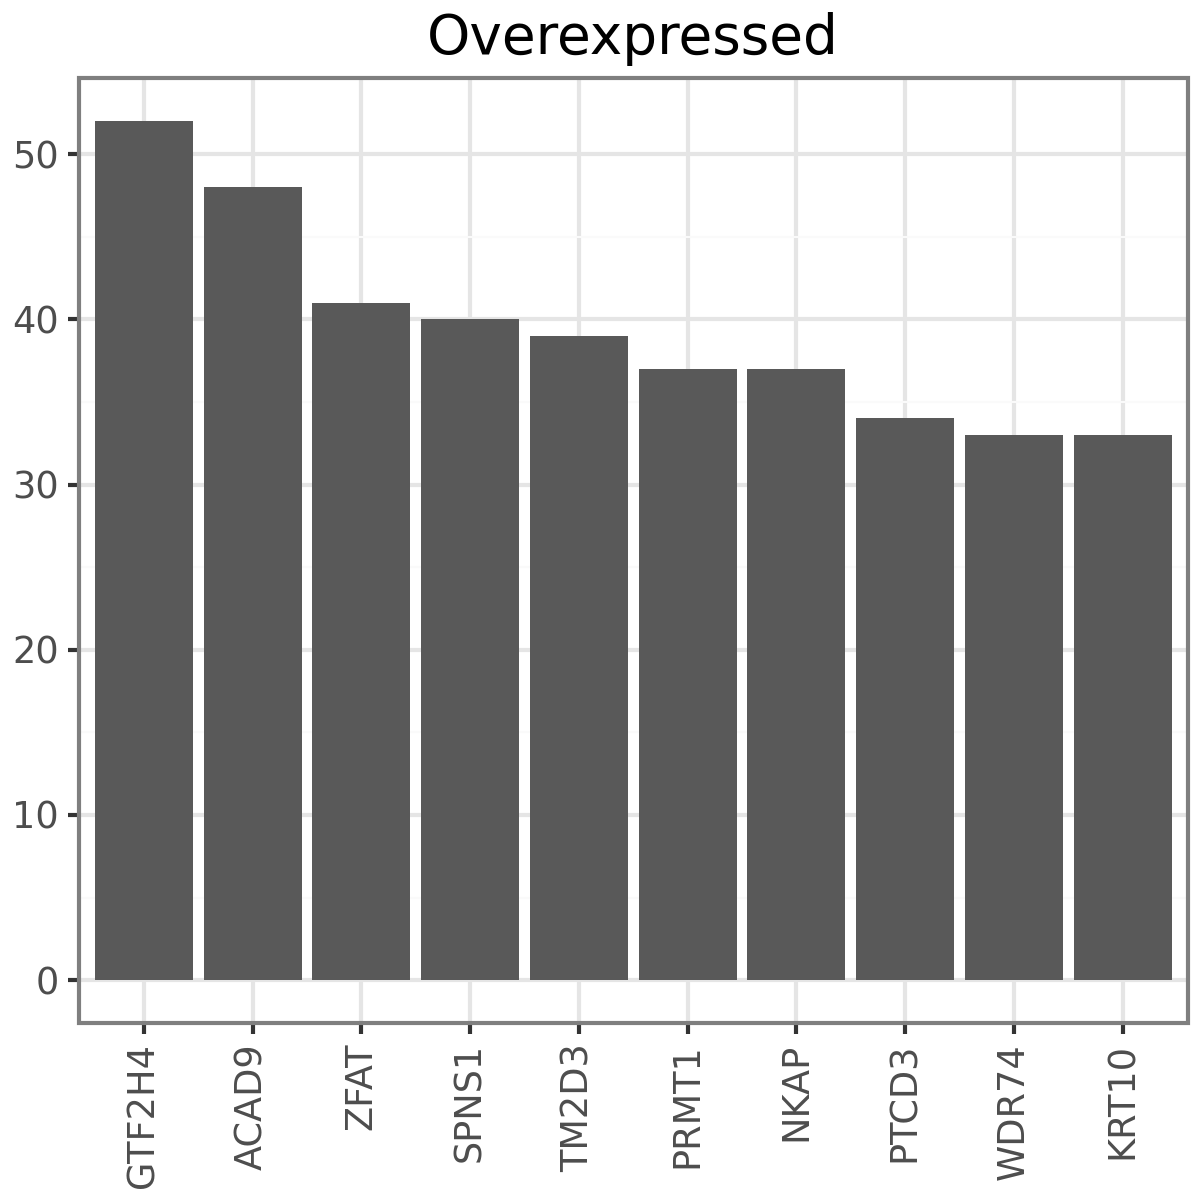

In [61]:
# Create the bar plot
p = (pn.ggplot(over_df, pn.aes(x='symbol', y='len')) +
        pn.geom_bar(stat='identity', position='dodge') +
        pn.scale_fill_manual(['#D3D3D3', '#A9A9A9']) +
        pn.theme(
            figure_size=(4, 4),
            axis_text_x=pn.element_text(angle=90),
            dpi=150,
        ) +
        pn.labs(y='', x='', title='Overexpressed', fill='Outlier state'))
p

In [62]:
p.save("overexpressed_genes.pdf", width=4, height=4, dpi=300)

/opt/modules/i12g/anaconda/envs/kipoi-veff-analysis/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4 x 4 in image.
/opt/modules/i12g/anaconda/envs/kipoi-veff-analysis/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: overexpressed_genes.pdf


In [63]:
under_df

gene,outlier_state,len,symbol
str,enum,u32,enum
"""ENSG00000140157""","""underexpressed""",67,"""NIPA2"""
"""ENSG00000093144""","""underexpressed""",66,"""ECHDC1"""
"""ENSG00000273749""","""underexpressed""",65,"""CYFIP1"""
"""ENSG00000160072""","""underexpressed""",64,"""ATAD3B"""
"""ENSG00000115839""","""underexpressed""",47,"""RAB3GAP1"""
"""ENSG00000166557""","""underexpressed""",43,"""TMED3"""
"""ENSG00000186470""","""underexpressed""",42,"""BTN3A2"""
"""ENSG00000265491""","""underexpressed""",39,"""RNF115"""
"""ENSG00000265681""","""underexpressed""",38,"""RPL17"""


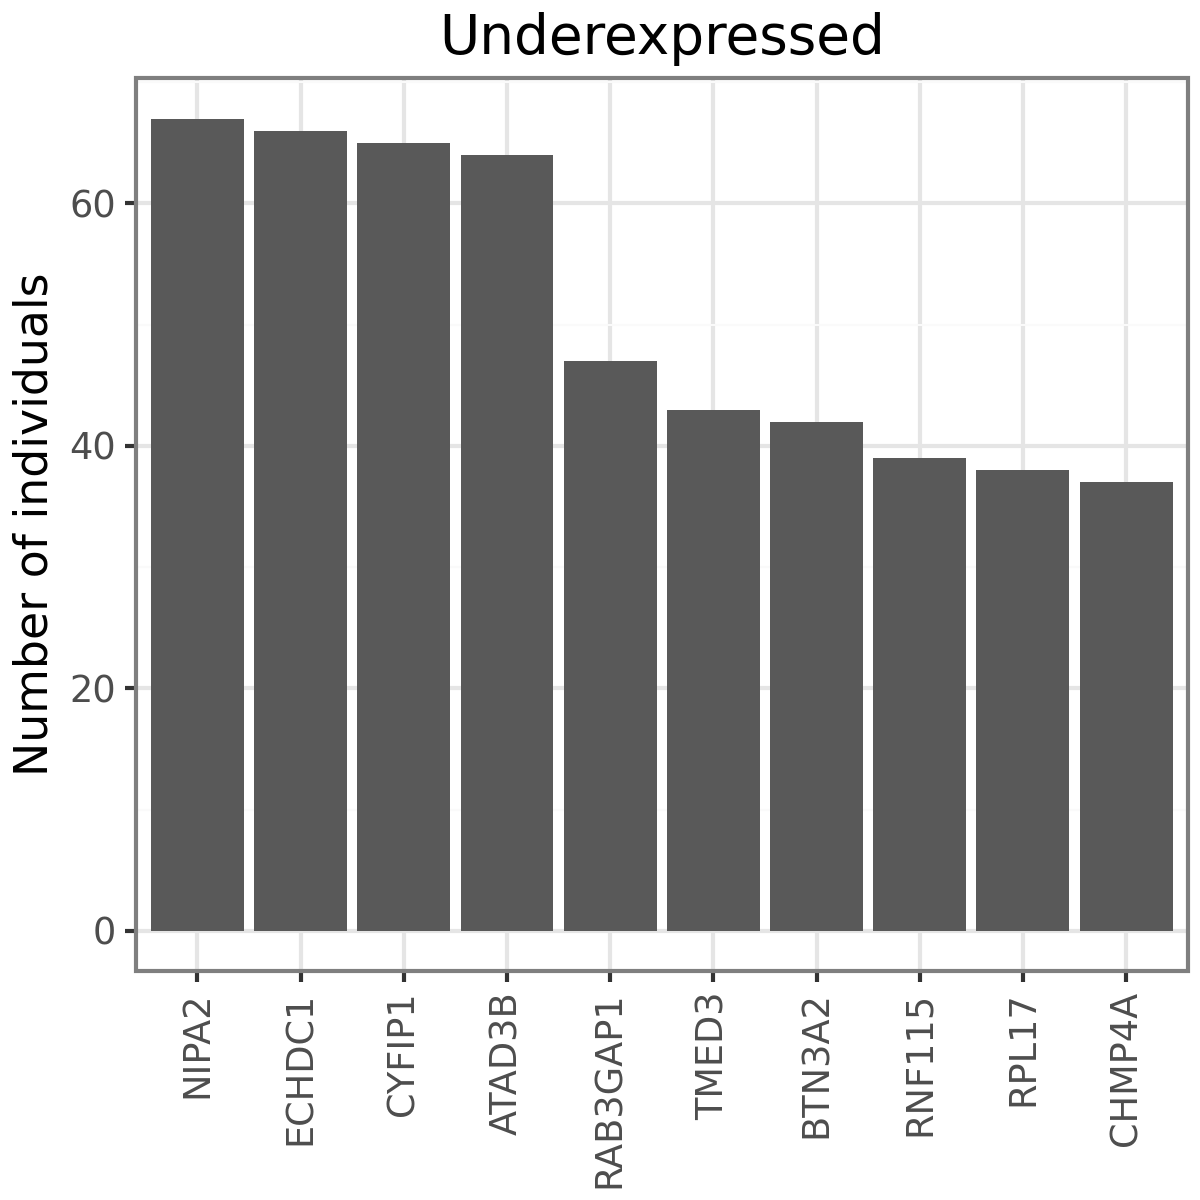

In [64]:
# Create the bar plot
p = (pn.ggplot(under_df[:10], pn.aes(x='symbol', y='len')) +
        pn.geom_bar(stat='identity', position='dodge') +
        pn.scale_fill_manual(['#D3D3D3', '#A9A9A9']) +
        pn.theme(
            figure_size=(4, 4),
            axis_text_x=pn.element_text(angle=90),
            dpi=150,
        ) +
        pn.labs(y='Number of individuals', x='', title='Underexpressed', fill='Outlier state'))
p

In [65]:
p.save("underexpressed_genes.pdf", width=4, height=4, dpi=300)

/opt/modules/i12g/anaconda/envs/kipoi-veff-analysis/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4 x 4 in image.
/opt/modules/i12g/anaconda/envs/kipoi-veff-analysis/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: underexpressed_genes.pdf
